# LCPB 20-21 exercise 3

### Saverio Monaco

### Gerardo Carmona

### Hilario Capettini

In [1]:
import numpy as np
from numpy.random import seed
seed(12345)
import tensorflow  
tensorflow.random.set_seed(12345)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D,GlobalMaxPooling1D,GlobalAveragePooling1D
from keras import optimizers
from keras import initializers,regularizers

import seaborn as sns

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [2]:
def data_import(fnamex,fnamey):
    x = np.loadtxt(fnamex,delimiter=',',dtype=float)
    N = len(x)
    print('Length of x = ',N)

    categ = np.loadtxt(fnamey,delimiter=',', dtype=int)
    #Number of categories
    N_categ = len(np.unique(categ))
    y = np.zeros((N,N_categ))

    for n in range(N):
        y[n][categ[n]] = 1

    return x,y,N
    

def set_spliting(N,x,y,perc_train = 0.8):  
    N_train = int(N * perc_train)
    N_val = N-N_train

    x_train = x[:N_train]
    y_train = y[:N_train]

    x_val = x[N_train:]
    y_val = y[N_train:]
    
    L =len(x[0])
    
    x_train = x_train.reshape(x_train.shape[0],L,1)
    x_val = x_val.reshape(x_val.shape[0],L,1)
    input_shape = (L,1)

    return x_train, y_train, x_val, y_val, input_shape
    
def data_process(x,N):
    xm = x.mean(axis=1)
    for n in range(N):
        x[n] = x[n]-xm[n]
    
    std = x.std(axis=1)
    for n in range(N):
        x[n] = x[n] / std[n]
        
    return x

def build_model(loss,first_layer,deep_layers,output_size,output_activation = 'softmax', opt = optimizers.Adam()):
    seed(12345)
    tensorflow.random.set_seed(12345)
    model = Sequential()
    model.add(first_layer)
    for layer in layers: model.add(layer)
    model.add(Dense(output_size,activation = output_activation))
    model.compile(loss=loss,optimizer=opt,metrics=['accuracy'])

    return model


In [3]:
def plot_confusionmatrix(y_pred, y_true, normalization = False):
    # Insted of having y = [0,0,1] , [0,1,0] and [1,0,0] as labels, we transform them in
    # y = 0, 1 ,2
    y_true_mod = np.argmax(y_true, axis=1) #tells wich of the 3 argument is max
    # same for the prediction
    y_pred_mod = np.argmax(y_pred, axis=1)
    # N.B: if we don't do that we get the following error: 
    # ValueError: Classification metrics can't handle a mix of continuous-multioutput and multilabel-indicator targets
    conf_mat = confusion_matrix(y_true_mod, y_pred_mod) # doing the same makes sense, we take the argument
                                                        # with the highest value (i.e more probable)
    if normalization:
        norm = np.sum(np.sum(conf_mat,axis=1))
        conf_mat = conf_mat / norm
        #print(norm)
        # check that it is normalized
        #print(np.sum(np.sum(conf_mat,axis=0)))
    fig, ax = plt.subplots(figsize=(10,10))
    if not normalization:
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap = "mako")
    if normalization:
        sns.heatmap(conf_mat, annot=True, fmt='f', cmap = "mako")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def plot_accuracyloss(fit, title = False):
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    axs = [ax1,ax2]
    obs = ['accuracy','loss']
    for i in range(2):
        axs[i].plot(fit.history[obs[i]],'r',label =obs[i]+' of training data')
        #dashed line!!
        axs[i].plot(fit.history['val_'+obs[i]],'b--',
            label =obs[i]+' of validation data')
        axs[i].set_ylabel(obs[i])
        axs[i].set_xlabel('epochs')
        if title:
            axs[i].set_title(title)
        axs[i].legend()

In [4]:
#File importation
x, y, N = data_import("DATA/x_ts_L60_Z12_A500_DX50_bias5_N10000.csv",
                      "DATA/y_ts_L60_Z12_A500_DX50_bias5_N10000.csv")
x = data_process(x,N)
x_train, y_train, x_val, y_val, input_shape = set_spliting(N,x,y)

Length of x =  10000


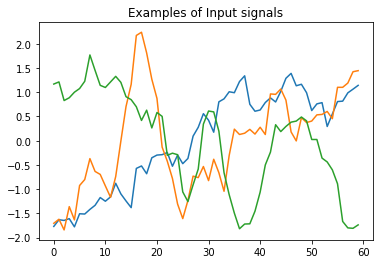

In [5]:
#Data visualization
plt.title('Examples of Input signals')
plt.plot(x[0])
plt.plot(x[1])
plt.plot(x[2])
plt.show()

In [6]:
reg = regularizers.l1(0.01)    
#Now we initialize the NN weights
ini = initializers.RandomNormal(mean=0,stddev=0.05)
conv_lay = lambda shape: Conv1D(filters =5, kernel_size =11, kernel_regularizer = reg, kernel_initializer = ini, activation = 'relu', input_shape = shape)

layers = [
    AveragePooling1D(5),
    Conv1D(filters=5,kernel_size=7,activation="relu"),
    Flatten(),
    Dense(10,activation='relu'),
    Dropout(0.2)]


model = build_model(keras.losses.categorical_crossentropy,conv_lay(input_shape), layers, 3)
                    
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d (AveragePo (None, 10, 5)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4, 5)              180       
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [7]:
batch_size =250
epochs = 100

fit = model.fit(x_train,y_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x_val,y_val),
               verbose=2, shuffle=True)

Epoch 1/100
32/32 - 1s - loss: 1.1139 - accuracy: 0.3525 - val_loss: 1.1040 - val_accuracy: 0.4070
Epoch 2/100
32/32 - 1s - loss: 1.0982 - accuracy: 0.3945 - val_loss: 1.0897 - val_accuracy: 0.4140
Epoch 3/100
32/32 - 1s - loss: 1.0830 - accuracy: 0.4074 - val_loss: 1.0742 - val_accuracy: 0.4255
Epoch 4/100
32/32 - 1s - loss: 1.0690 - accuracy: 0.4317 - val_loss: 1.0568 - val_accuracy: 0.4640
Epoch 5/100
32/32 - 1s - loss: 1.0499 - accuracy: 0.4545 - val_loss: 1.0351 - val_accuracy: 0.4910
Epoch 6/100
32/32 - 1s - loss: 1.0285 - accuracy: 0.4696 - val_loss: 1.0143 - val_accuracy: 0.5145
Epoch 7/100
32/32 - 1s - loss: 1.0072 - accuracy: 0.4856 - val_loss: 0.9910 - val_accuracy: 0.5085
Epoch 8/100
32/32 - 1s - loss: 0.9887 - accuracy: 0.5086 - val_loss: 0.9771 - val_accuracy: 0.5110
Epoch 9/100
32/32 - 1s - loss: 0.9756 - accuracy: 0.5024 - val_loss: 0.9592 - val_accuracy: 0.5320
Epoch 10/100
32/32 - 1s - loss: 0.9571 - accuracy: 0.5176 - val_loss: 0.9472 - val_accuracy: 0.5480
Epoch 11/

32/32 - 1s - loss: 0.6542 - accuracy: 0.7526 - val_loss: 0.6616 - val_accuracy: 0.7435
Epoch 84/100
32/32 - 1s - loss: 0.6580 - accuracy: 0.7563 - val_loss: 0.6546 - val_accuracy: 0.7500
Epoch 85/100
32/32 - 1s - loss: 0.6585 - accuracy: 0.7523 - val_loss: 0.6586 - val_accuracy: 0.7455
Epoch 86/100
32/32 - 1s - loss: 0.6521 - accuracy: 0.7520 - val_loss: 0.6483 - val_accuracy: 0.7575
Epoch 87/100
32/32 - 1s - loss: 0.6526 - accuracy: 0.7476 - val_loss: 0.6452 - val_accuracy: 0.7585
Epoch 88/100
32/32 - 1s - loss: 0.6548 - accuracy: 0.7539 - val_loss: 0.6467 - val_accuracy: 0.7655
Epoch 89/100
32/32 - 1s - loss: 0.6459 - accuracy: 0.7590 - val_loss: 0.6386 - val_accuracy: 0.7605
Epoch 90/100
32/32 - 1s - loss: 0.6399 - accuracy: 0.7595 - val_loss: 0.6363 - val_accuracy: 0.7650
Epoch 91/100
32/32 - 1s - loss: 0.6334 - accuracy: 0.7636 - val_loss: 0.6355 - val_accuracy: 0.7685
Epoch 92/100
32/32 - 1s - loss: 0.6354 - accuracy: 0.7653 - val_loss: 0.6358 - val_accuracy: 0.7650
Epoch 93/100


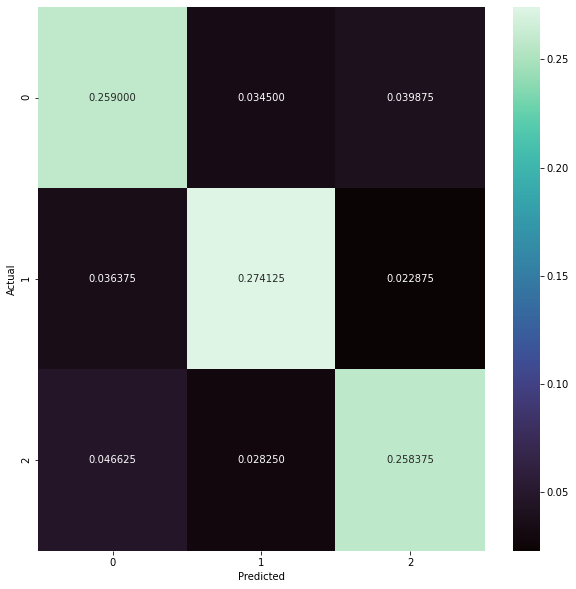

In [8]:
results = model.predict(x_train)
plot_confusionmatrix(results,y_train, normalization = True)

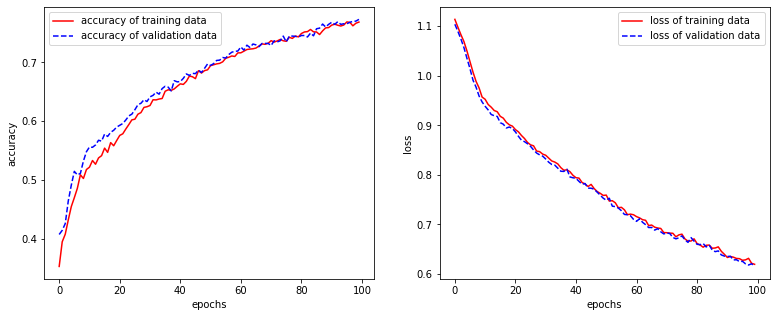

In [9]:

plot_accuracyloss(fit)

## 2 
By reducing the signal-to-noise ratio, namely the
amplitude of the external signal in the data (A) with
respect to the step typical size DX of the jump process,
check where the network (defined in the class) starts to
fail discriminating the categories.


In [10]:
x1,y1,N1 = data_import("DATA/x_ts_L60_Z12_A10_DX50_bias5_N10000.csv","DATA/y_ts_L60_Z12_A10_DX50_bias5_N10000.csv")
x2,y2,N2 = data_import("DATA/x_ts_L60_Z12_A100_DX50_bias5_N10000.csv","DATA/y_ts_L60_Z12_A100_DX50_bias5_N10000.csv")
x3,y3,N3 = data_import("DATA/x_ts_L60_Z12_A500_DX50_bias5_N10000.csv","DATA/y_ts_L60_Z12_A1000_DX50_bias5_N10000.csv")
x4,y4,N4 = data_import("DATA/x_ts_L60_Z12_A1000_DX50_bias5_N10000.csv","DATA/y_ts_L60_Z12_A10000_DX50_bias5_N10000.csv")


Length of x =  10000
Length of x =  10000
Length of x =  10000
Length of x =  10000


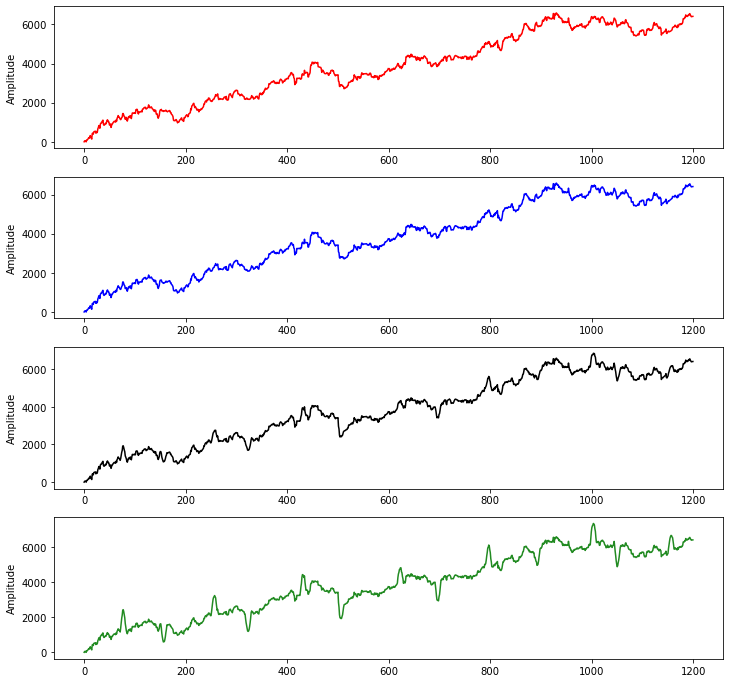

In [11]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, ncols=1, figsize=(12, 12))

xs  = [x1 ,x2 ,x3 ,x4]
pltx1 = x1.copy() #this will be useful for later plot, x1 x2,... will be changed
pltx2 = x2.copy()
pltx3 = x3.copy()
pltx4 = x4.copy()
raw_sig = np.array(xs, copy=True) 
axs = [ax1,ax2,ax3,ax4]
colors = ['red','blue','black','forestgreen']

for k in range(len(xs)): 
    for j in range(20):
        axs[k].plot([i for i in range(j*len(xs[k][0]),(len(xs[k][0])+j*len(xs[k][0])))],xs[k][j],color=colors[k])
        axs[k].set_ylabel('Amplitude', fontsize=10)
plt.show()

In [12]:
x1 = data_process(x1,N1)
x2 = data_process(x2,N2)
x3 = data_process(x3,N3)
x4 = data_process(x4,N4)

x1_train, y1_train, x1_val, y1_val, input_shape1 = set_spliting(N1,x1,y1,perc_train = 0.8)
x2_train, y2_train, x2_val, y2_val, input_shape2 = set_spliting(N2,x2,y2,perc_train = 0.8)
x3_train, y3_train, x3_val, y3_val, input_shape3 = set_spliting(N3,x3,y3,perc_train = 0.8)
x4_train, y4_train, x4_val, y4_val, input_shape4 = set_spliting(N4,x4,y4,perc_train = 0.8)

In [14]:
batch_size =250
epochs = 100


fit1 = build_model(keras.losses.categorical_crossentropy,conv_lay(input_shape1),layers,3).fit(x1_train,y1_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x1_val,y1_val),
               verbose=2, shuffle=True)

fit2 = build_model(keras.losses.categorical_crossentropy,conv_lay(input_shape2),layers,3).fit(x2_train,y2_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x2_val,y2_val),
               verbose=2, shuffle=True)

fit3 = build_model(keras.losses.categorical_crossentropy,conv_lay(input_shape3),layers,3).fit(x3_train,y3_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x3_val,y3_val),
               verbose=2, shuffle=True)

fit4 = build_model(keras.losses.categorical_crossentropy,conv_lay(input_shape4),layers,3).fit(x4_train,y4_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x4_val,y4_val),
               verbose=2, shuffle=True)

Epoch 1/100
32/32 - 1s - loss: 1.2440 - accuracy: 0.3379 - val_loss: 1.1195 - val_accuracy: 0.3260
Epoch 2/100
32/32 - 1s - loss: 1.1206 - accuracy: 0.3376 - val_loss: 1.1124 - val_accuracy: 0.3340
Epoch 3/100
32/32 - 1s - loss: 1.1137 - accuracy: 0.3301 - val_loss: 1.1076 - val_accuracy: 0.3245
Epoch 4/100
32/32 - 1s - loss: 1.1104 - accuracy: 0.3355 - val_loss: 1.1058 - val_accuracy: 0.3280
Epoch 5/100
32/32 - 1s - loss: 1.1081 - accuracy: 0.3295 - val_loss: 1.1045 - val_accuracy: 0.3430
Epoch 6/100
32/32 - 1s - loss: 1.1071 - accuracy: 0.3266 - val_loss: 1.1035 - val_accuracy: 0.3340
Epoch 7/100
32/32 - 1s - loss: 1.1059 - accuracy: 0.3309 - val_loss: 1.1027 - val_accuracy: 0.3350
Epoch 8/100
32/32 - 1s - loss: 1.1048 - accuracy: 0.3271 - val_loss: 1.1019 - val_accuracy: 0.3330
Epoch 9/100
32/32 - 1s - loss: 1.1036 - accuracy: 0.3239 - val_loss: 1.1013 - val_accuracy: 0.3335
Epoch 10/100
32/32 - 1s - loss: 1.1023 - accuracy: 0.3380 - val_loss: 1.1007 - val_accuracy: 0.3345
Epoch 11/

32/32 - 1s - loss: 1.0987 - accuracy: 0.3356 - val_loss: 1.0987 - val_accuracy: 0.3330
Epoch 84/100
32/32 - 1s - loss: 1.0988 - accuracy: 0.3236 - val_loss: 1.0987 - val_accuracy: 0.3335
Epoch 85/100
32/32 - 1s - loss: 1.0988 - accuracy: 0.3284 - val_loss: 1.0987 - val_accuracy: 0.3335
Epoch 86/100
32/32 - 1s - loss: 1.0988 - accuracy: 0.3343 - val_loss: 1.0987 - val_accuracy: 0.3330
Epoch 87/100
32/32 - 1s - loss: 1.0987 - accuracy: 0.3302 - val_loss: 1.0987 - val_accuracy: 0.3335
Epoch 88/100
32/32 - 1s - loss: 1.0987 - accuracy: 0.3369 - val_loss: 1.0987 - val_accuracy: 0.3335
Epoch 89/100
32/32 - 1s - loss: 1.0987 - accuracy: 0.3275 - val_loss: 1.0987 - val_accuracy: 0.3330
Epoch 90/100
32/32 - 1s - loss: 1.0988 - accuracy: 0.3234 - val_loss: 1.0987 - val_accuracy: 0.3335
Epoch 91/100
32/32 - 1s - loss: 1.0988 - accuracy: 0.3269 - val_loss: 1.0987 - val_accuracy: 0.3335
Epoch 92/100
32/32 - 1s - loss: 1.0988 - accuracy: 0.3301 - val_loss: 1.0987 - val_accuracy: 0.3335
Epoch 93/100


Epoch 66/100
32/32 - 1s - loss: 1.0984 - accuracy: 0.3460 - val_loss: 1.0993 - val_accuracy: 0.3250
Epoch 67/100
32/32 - 1s - loss: 1.0988 - accuracy: 0.3409 - val_loss: 1.0989 - val_accuracy: 0.3425
Epoch 68/100
32/32 - 1s - loss: 1.0985 - accuracy: 0.3478 - val_loss: 1.0983 - val_accuracy: 0.3490
Epoch 69/100
32/32 - 1s - loss: 1.0985 - accuracy: 0.3478 - val_loss: 1.0981 - val_accuracy: 0.3435
Epoch 70/100
32/32 - 1s - loss: 1.0982 - accuracy: 0.3444 - val_loss: 1.0981 - val_accuracy: 0.3465
Epoch 71/100
32/32 - 1s - loss: 1.0985 - accuracy: 0.3425 - val_loss: 1.0988 - val_accuracy: 0.3425
Epoch 72/100
32/32 - 1s - loss: 1.0989 - accuracy: 0.3415 - val_loss: 1.0986 - val_accuracy: 0.3370
Epoch 73/100
32/32 - 1s - loss: 1.0981 - accuracy: 0.3498 - val_loss: 1.0988 - val_accuracy: 0.3480
Epoch 74/100
32/32 - 1s - loss: 1.0986 - accuracy: 0.3445 - val_loss: 1.0981 - val_accuracy: 0.3435
Epoch 75/100
32/32 - 1s - loss: 1.0983 - accuracy: 0.3507 - val_loss: 1.0982 - val_accuracy: 0.3530


32/32 - 1s - loss: 0.5609 - accuracy: 0.7977 - val_loss: 0.5212 - val_accuracy: 0.8170
Epoch 49/100
32/32 - 1s - loss: 0.5627 - accuracy: 0.8009 - val_loss: 0.5142 - val_accuracy: 0.8180
Epoch 50/100
32/32 - 1s - loss: 0.5487 - accuracy: 0.8000 - val_loss: 0.5153 - val_accuracy: 0.8175
Epoch 51/100
32/32 - 1s - loss: 0.5522 - accuracy: 0.8040 - val_loss: 0.5202 - val_accuracy: 0.8170
Epoch 52/100
32/32 - 1s - loss: 0.5599 - accuracy: 0.8016 - val_loss: 0.5127 - val_accuracy: 0.8195
Epoch 53/100
32/32 - 1s - loss: 0.5511 - accuracy: 0.8034 - val_loss: 0.5115 - val_accuracy: 0.8170
Epoch 54/100
32/32 - 1s - loss: 0.5465 - accuracy: 0.8064 - val_loss: 0.5103 - val_accuracy: 0.8190
Epoch 55/100
32/32 - 0s - loss: 0.5483 - accuracy: 0.8001 - val_loss: 0.5092 - val_accuracy: 0.8180
Epoch 56/100
32/32 - 1s - loss: 0.5474 - accuracy: 0.8024 - val_loss: 0.5095 - val_accuracy: 0.8195
Epoch 57/100
32/32 - 1s - loss: 0.5405 - accuracy: 0.8070 - val_loss: 0.5070 - val_accuracy: 0.8220
Epoch 58/100


Epoch 31/100
32/32 - 1s - loss: 0.2941 - accuracy: 0.8989 - val_loss: 0.2372 - val_accuracy: 0.9265
Epoch 32/100
32/32 - 1s - loss: 0.2904 - accuracy: 0.9013 - val_loss: 0.2355 - val_accuracy: 0.9230
Epoch 33/100
32/32 - 1s - loss: 0.2898 - accuracy: 0.9001 - val_loss: 0.2299 - val_accuracy: 0.9280
Epoch 34/100
32/32 - 1s - loss: 0.2858 - accuracy: 0.9010 - val_loss: 0.2336 - val_accuracy: 0.9300
Epoch 35/100
32/32 - 2s - loss: 0.2793 - accuracy: 0.9124 - val_loss: 0.2301 - val_accuracy: 0.9320
Epoch 36/100
32/32 - 2s - loss: 0.2862 - accuracy: 0.9043 - val_loss: 0.2337 - val_accuracy: 0.9310
Epoch 37/100
32/32 - 2s - loss: 0.2851 - accuracy: 0.9068 - val_loss: 0.2288 - val_accuracy: 0.9290
Epoch 38/100
32/32 - 1s - loss: 0.2749 - accuracy: 0.9066 - val_loss: 0.2287 - val_accuracy: 0.9310
Epoch 39/100
32/32 - 2s - loss: 0.2826 - accuracy: 0.9068 - val_loss: 0.2252 - val_accuracy: 0.9305
Epoch 40/100
32/32 - 1s - loss: 0.2809 - accuracy: 0.9069 - val_loss: 0.2331 - val_accuracy: 0.9285


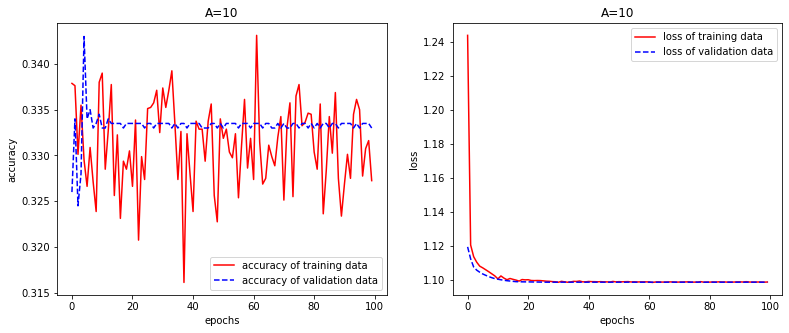

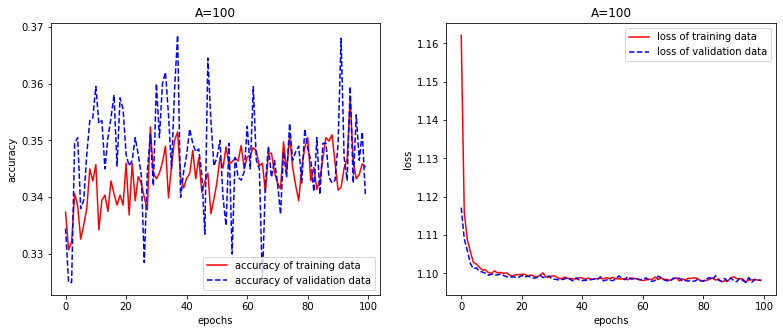

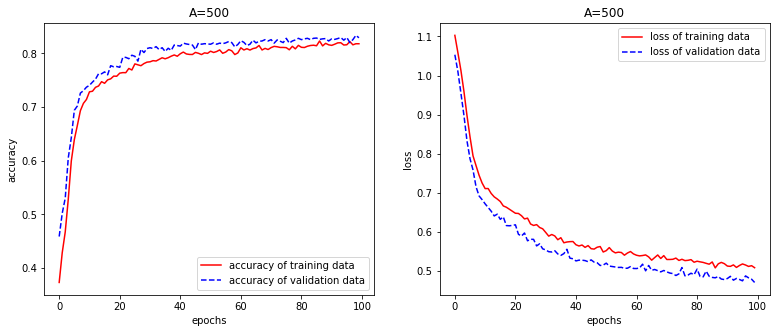

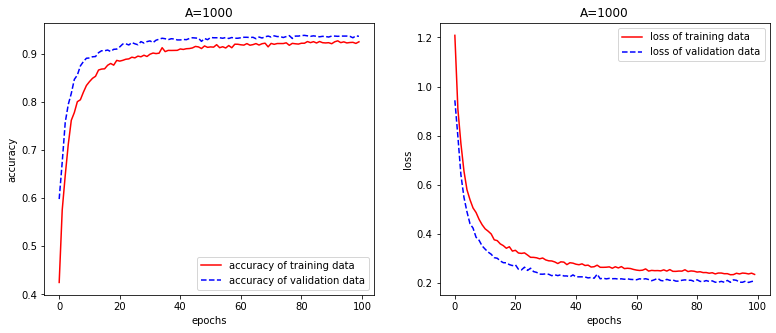

In [15]:
fits =        [fit1,fit2,fit3,fit4]
pattern_mag = [10,100,500,1000]
for i in range(len(fits)):
    plot_accuracyloss(fits[i],title='A='+str(pattern_mag[i]))

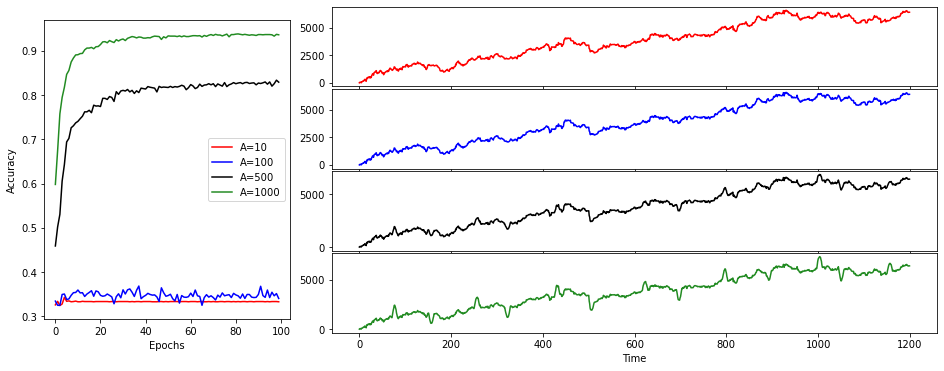

In [16]:
import matplotlib.gridspec as gridspec
pltxs = [pltx1,pltx2,pltx3,pltx4]
plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(24, 25)
for k in range(len(xs)): 
    axs[k] = plt.subplot(gs[6*k:6*k+6, 8:])
    for j in range(20):
        axs[k].plot([i for i in range(j*len(pltxs[k][0]),(len(pltxs[k][0])+j*len(pltxs[k][0])))],pltxs[k][j],color=colors[k])
axs[k].set_xlabel('Time')
axloss = plt.subplot(gs[1:-1, :7])
for i in range(len(fits)):
    axloss.plot(fits[i].history['val_accuracy'],c=colors[i],label='A='+str(pattern_mag[i]))
    axloss.set_xlabel('Epochs')
    axloss.set_ylabel('Accuracy')
    axloss.legend()
    

From this plot can be seen that as the amplitude of the characteristic patterns is increased (right plot) it is easier for the CNN to learn the pattern. It can be seen from the left plot where the accuracy of the CNN over the test data is depicted.  

3. Try another version where only one convolutional layer is
introduced instead of two, and where any number of
dense layers may be used, with the global constraint of
using a network with at most $600$ trainable parameters.

Is the number of parameters scaling more quickly by adding Dense layers or Conv1D
layers?

In [4]:

x, y, N = data_import("DATA/x_ts_comp_N10000.csv","DATA/y_ts_comp_N10000.csv")
x = data_process(x,N)
x_train, y_train, x_val, y_val, input_shape = set_spliting(N,x,y)
output_size =len(y_train[0])

Length of x =  10000


In [5]:
# Build the model

reg = regularizers.l1(0.01)
#Now we initialize the NN weights
ini = initializers.RandomNormal(mean=0,stddev=0.05)
conv_lay = lambda shape: Conv1D(filters =5, kernel_size =11, kernel_regularizer = reg, kernel_initializer = ini, activation = 'relu', input_shape = shape)

layers = [AveragePooling1D(5),
          Flatten(),
          Dense(6,activation='relu'),
          Dropout(0.2),
          Dense(12,activation='relu'),
          Dense(9,activation='relu')]

model_1 = build_model(keras.losses.categorical_crossentropy,conv_lay(input_shape), layers, output_size)

print(model_1.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d (AveragePo (None, 10, 5)             0         
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 306       
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                84        
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1

In [6]:
batch_size =250
epochs = 200

fit_1 = model_1.fit(x_train,y_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x_val,y_val),
               verbose=2, shuffle=True)

Epoch 1/200
32/32 - 1s - loss: 1.1148 - accuracy: 0.3236 - val_loss: 1.1086 - val_accuracy: 0.3470
Epoch 2/200
32/32 - 1s - loss: 1.1052 - accuracy: 0.3279 - val_loss: 1.1021 - val_accuracy: 0.3285
Epoch 3/200
32/32 - 1s - loss: 1.1006 - accuracy: 0.3425 - val_loss: 1.0994 - val_accuracy: 0.3710
Epoch 4/200
32/32 - 1s - loss: 1.0992 - accuracy: 0.3391 - val_loss: 1.0989 - val_accuracy: 0.3575
Epoch 5/200
32/32 - 1s - loss: 1.0989 - accuracy: 0.3417 - val_loss: 1.0987 - val_accuracy: 0.3730
Epoch 6/200
32/32 - 1s - loss: 1.0988 - accuracy: 0.3428 - val_loss: 1.0984 - val_accuracy: 0.3865
Epoch 7/200
32/32 - 1s - loss: 1.0989 - accuracy: 0.3399 - val_loss: 1.0983 - val_accuracy: 0.3725
Epoch 8/200
32/32 - 0s - loss: 1.0986 - accuracy: 0.3591 - val_loss: 1.0980 - val_accuracy: 0.3795
Epoch 9/200
32/32 - 1s - loss: 1.0981 - accuracy: 0.3584 - val_loss: 1.0964 - val_accuracy: 0.3955
Epoch 10/200
32/32 - 1s - loss: 1.0953 - accuracy: 0.3734 - val_loss: 1.0907 - val_accuracy: 0.3980
Epoch 11/

32/32 - 1s - loss: 0.7044 - accuracy: 0.6649 - val_loss: 0.6446 - val_accuracy: 0.7185
Epoch 84/200
32/32 - 0s - loss: 0.7050 - accuracy: 0.6714 - val_loss: 0.6541 - val_accuracy: 0.6965
Epoch 85/200
32/32 - 0s - loss: 0.7036 - accuracy: 0.6733 - val_loss: 0.6426 - val_accuracy: 0.7145
Epoch 86/200
32/32 - 1s - loss: 0.7062 - accuracy: 0.6756 - val_loss: 0.6515 - val_accuracy: 0.7140
Epoch 87/200
32/32 - 0s - loss: 0.6958 - accuracy: 0.6730 - val_loss: 0.6392 - val_accuracy: 0.7235
Epoch 88/200
32/32 - 0s - loss: 0.7035 - accuracy: 0.6683 - val_loss: 0.6531 - val_accuracy: 0.7175
Epoch 89/200
32/32 - 1s - loss: 0.6956 - accuracy: 0.6740 - val_loss: 0.6436 - val_accuracy: 0.7205
Epoch 90/200
32/32 - 0s - loss: 0.7010 - accuracy: 0.6715 - val_loss: 0.6367 - val_accuracy: 0.7360
Epoch 91/200
32/32 - 1s - loss: 0.7007 - accuracy: 0.6699 - val_loss: 0.6363 - val_accuracy: 0.7275
Epoch 92/200
32/32 - 0s - loss: 0.6868 - accuracy: 0.6779 - val_loss: 0.6375 - val_accuracy: 0.7315
Epoch 93/200


Epoch 165/200
32/32 - 0s - loss: 0.6558 - accuracy: 0.7032 - val_loss: 0.6151 - val_accuracy: 0.7475
Epoch 166/200
32/32 - 0s - loss: 0.6601 - accuracy: 0.6955 - val_loss: 0.6128 - val_accuracy: 0.7425
Epoch 167/200
32/32 - 1s - loss: 0.6482 - accuracy: 0.7069 - val_loss: 0.6067 - val_accuracy: 0.7445
Epoch 168/200
32/32 - 1s - loss: 0.6564 - accuracy: 0.6963 - val_loss: 0.6092 - val_accuracy: 0.7440
Epoch 169/200
32/32 - 0s - loss: 0.6586 - accuracy: 0.6959 - val_loss: 0.6243 - val_accuracy: 0.7320
Epoch 170/200
32/32 - 1s - loss: 0.6591 - accuracy: 0.6985 - val_loss: 0.6084 - val_accuracy: 0.7500
Epoch 171/200
32/32 - 1s - loss: 0.6554 - accuracy: 0.6984 - val_loss: 0.6072 - val_accuracy: 0.7475
Epoch 172/200
32/32 - 1s - loss: 0.6500 - accuracy: 0.7054 - val_loss: 0.6068 - val_accuracy: 0.7405
Epoch 173/200
32/32 - 1s - loss: 0.6576 - accuracy: 0.6966 - val_loss: 0.6080 - val_accuracy: 0.7480
Epoch 174/200
32/32 - 1s - loss: 0.6575 - accuracy: 0.7023 - val_loss: 0.6179 - val_accurac

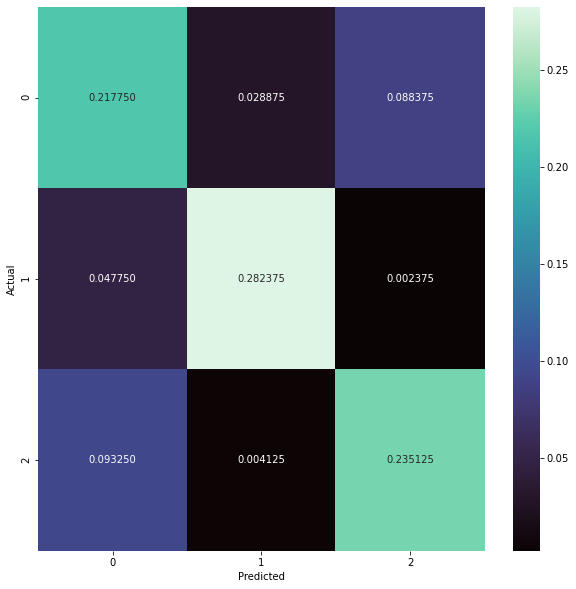

In [7]:
results = model_1.predict(x_train)
plot_confusionmatrix(results,y_train, normalization = True)

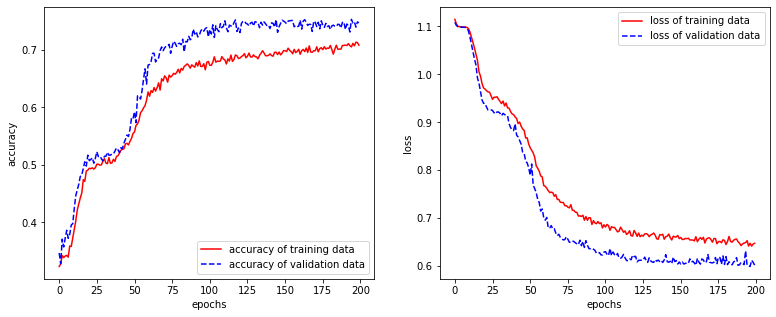

In [8]:
plot_accuracyloss(fit_1)

4. Check if regularization may improve the performances by varying the parameter lambda of
the L1 (LASSO) or of the L2 (Ridge) regularization; see lambda in eqs.(43) and (52) in the
review. There is also a mixed version (l1_l2) that can be tried.

    1. Is there any intermediate value of lambda where the performances of the network are better?

    2. Is there any improvement in the visualization and understanding of the weights in the filters?

Note that the regularization we introduced acts on the w’s, not on the biases. One can also
try the equivalent procedure for biases or for the output of the relu units (see Keras doc.), if
there is any reason for suspecting that it may help. In our case, the logic was to let the
weights of the filters go to zero if not needed, hence that kind of regularization was selected.

In [9]:
from keras.regularizers import l1_l2
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


lam = np.logspace(-1,-3,3).tolist()


In [10]:
def reg_conv_lay(l1,l2):
    return Conv1D(filters =5, kernel_size =11, kernel_regularizer = l1_l2(l1 = l1, l2 = l2), kernel_initializer = ini, activation = 'relu', input_shape = input_shape)

def compile_model(l1,l2):

    model = build_model(keras.losses.categorical_crossentropy,reg_conv_lay(l1,l2),layers,output_size)
    
    return model

# Using Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=200,
                        batch_size = 250, 
                        verbose=2)

# parameters dictionary
param_grid = dict(l1 = lam,l2=lam)
# Run gridsearch
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
best_model = grid_result.best_estimator_

PicklingError: Could not pickle the task to send it to the workers.

EXTRA: If there is time, draw the confusion matrix for a CNN model trained with the sequence data of the
exercise 02.

In [11]:
#File importation
ex_x, ex_y, ex_N = data_import("DATA/sequences16_x_augmented.csv",
                      "DATA/sequences16_y_augmented.csv")
ex_x = data_process(ex_x,ex_N)

#Now we permutate the samples 
permutation = np.random.permutation(ex_x.shape[0])

ex_x = ex_x[permutation] 
ex_y = ex_y[permutation]

ex_x_train, ex_y_train, ex_x_val, ex_y_val, ex_input_shape = set_spliting(ex_N,ex_x,ex_y,perc_train = 0.8)

ex_N_categ = len(np.unique(ex_y[0]))

Length of x =  48000


In [12]:
reg = regularizers.l1(0.01)    
#Now we initialize the NN weights
ini = initializers.RandomNormal(mean=0,stddev=0.05)
conv_lay = lambda shape: Conv1D(filters =5, kernel_size =11, kernel_regularizer = reg, kernel_initializer = ini, activation = 'relu', input_shape = shape)

layers = [
    #AveragePooling1D(4),
    Conv1D(filters=5,kernel_size=7,activation="relu"),
    Flatten(),
    Dense(10,activation='relu'),
    Dropout(0.2)]

                             #Binary cross entropy is used
ex_model = build_model(keras.losses.binary_crossentropy,conv_lay(ex_input_shape), layers, ex_N_categ)

print(ex_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 54, 5)             60        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 5)             180       
_________________________________________________________________
flatten_1 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2410      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 22        
Total params: 2,672
Trainable params: 2,672
Non-trainable params: 0
____________________________________________________

In [13]:
batch_size =250
epochs = 200

ex_fit = ex_model.fit(ex_x_train,ex_y_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(ex_x_val,ex_y_val),
               verbose=2, shuffle=True)

Epoch 1/200
154/154 - 3s - loss: 0.5381 - accuracy: 0.7486 - val_loss: 0.4833 - val_accuracy: 0.7586
Epoch 2/200
154/154 - 5s - loss: 0.4735 - accuracy: 0.7524 - val_loss: 0.4323 - val_accuracy: 0.7586
Epoch 3/200
154/154 - 7s - loss: 0.4384 - accuracy: 0.8026 - val_loss: 0.4078 - val_accuracy: 0.8195
Epoch 4/200
154/154 - 7s - loss: 0.4230 - accuracy: 0.8189 - val_loss: 0.3974 - val_accuracy: 0.8338
Epoch 5/200
154/154 - 6s - loss: 0.4088 - accuracy: 0.8243 - val_loss: 0.3847 - val_accuracy: 0.8363
Epoch 6/200
154/154 - 5s - loss: 0.3970 - accuracy: 0.8352 - val_loss: 0.3679 - val_accuracy: 0.8489
Epoch 7/200
154/154 - 4s - loss: 0.3836 - accuracy: 0.8436 - val_loss: 0.3763 - val_accuracy: 0.8394
Epoch 8/200
154/154 - 4s - loss: 0.3772 - accuracy: 0.8501 - val_loss: 0.3510 - val_accuracy: 0.8640
Epoch 9/200
154/154 - 4s - loss: 0.3695 - accuracy: 0.8562 - val_loss: 0.3445 - val_accuracy: 0.8650
Epoch 10/200
154/154 - 6s - loss: 0.3656 - accuracy: 0.8610 - val_loss: 0.3464 - val_accura

Epoch 82/200
154/154 - 3s - loss: 0.3334 - accuracy: 0.8776 - val_loss: 0.3107 - val_accuracy: 0.8926
Epoch 83/200
154/154 - 3s - loss: 0.3352 - accuracy: 0.8768 - val_loss: 0.3090 - val_accuracy: 0.8928
Epoch 84/200
154/154 - 3s - loss: 0.3329 - accuracy: 0.8771 - val_loss: 0.3097 - val_accuracy: 0.8906
Epoch 85/200
154/154 - 3s - loss: 0.3336 - accuracy: 0.8789 - val_loss: 0.3107 - val_accuracy: 0.8863
Epoch 86/200
154/154 - 7s - loss: 0.3320 - accuracy: 0.8792 - val_loss: 0.3095 - val_accuracy: 0.8857
Epoch 87/200
154/154 - 6s - loss: 0.3332 - accuracy: 0.8783 - val_loss: 0.3087 - val_accuracy: 0.8953
Epoch 88/200
154/154 - 8s - loss: 0.3350 - accuracy: 0.8794 - val_loss: 0.3082 - val_accuracy: 0.8950
Epoch 89/200
154/154 - 5s - loss: 0.3309 - accuracy: 0.8775 - val_loss: 0.3220 - val_accuracy: 0.8800
Epoch 90/200
154/154 - 3s - loss: 0.3348 - accuracy: 0.8784 - val_loss: 0.3096 - val_accuracy: 0.8911
Epoch 91/200
154/154 - 3s - loss: 0.3311 - accuracy: 0.8795 - val_loss: 0.3072 - v

Epoch 162/200
154/154 - 4s - loss: 0.3279 - accuracy: 0.8827 - val_loss: 0.3035 - val_accuracy: 0.8968
Epoch 163/200
154/154 - 4s - loss: 0.3279 - accuracy: 0.8798 - val_loss: 0.3038 - val_accuracy: 0.8929
Epoch 164/200
154/154 - 4s - loss: 0.3275 - accuracy: 0.8814 - val_loss: 0.3036 - val_accuracy: 0.8951
Epoch 165/200
154/154 - 6s - loss: 0.3253 - accuracy: 0.8826 - val_loss: 0.3043 - val_accuracy: 0.8963
Epoch 166/200
154/154 - 9s - loss: 0.3254 - accuracy: 0.8824 - val_loss: 0.3027 - val_accuracy: 0.8964
Epoch 167/200
154/154 - 4s - loss: 0.3271 - accuracy: 0.8806 - val_loss: 0.3127 - val_accuracy: 0.8857
Epoch 168/200
154/154 - 6s - loss: 0.3278 - accuracy: 0.8814 - val_loss: 0.3061 - val_accuracy: 0.8946
Epoch 169/200
154/154 - 5s - loss: 0.3263 - accuracy: 0.8823 - val_loss: 0.3116 - val_accuracy: 0.8882
Epoch 170/200
154/154 - 5s - loss: 0.3236 - accuracy: 0.8841 - val_loss: 0.3072 - val_accuracy: 0.8948
Epoch 171/200
154/154 - 6s - loss: 0.3262 - accuracy: 0.8815 - val_loss: 

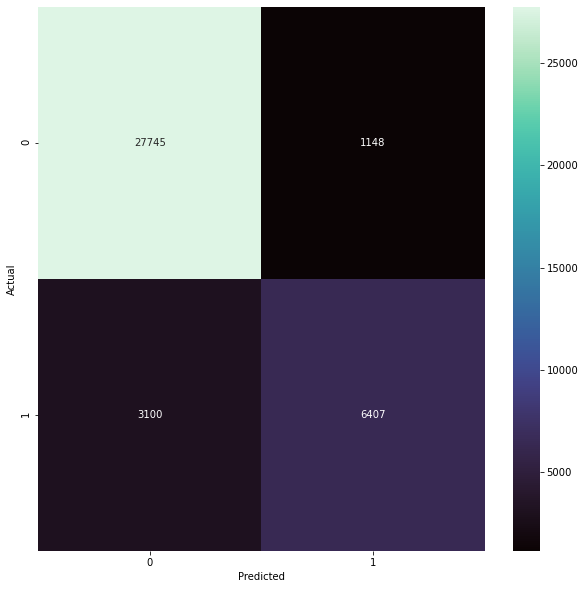

In [18]:
ex_results = ex_model.predict(ex_x_train)
plot_confusionmatrix(ex_results,ex_y_train, normalization = False)

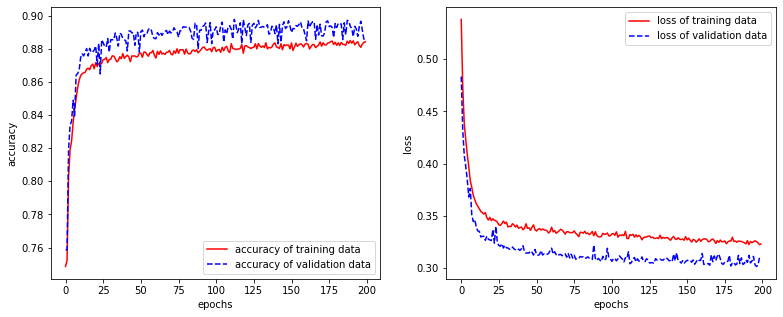

In [15]:
plot_accuracyloss(ex_fit, title = False)

The convolutional network used in this extra part is different since the data input is critically different aswell.
Our input data is an array of 64 ints (either 0 or 1 before preprocessing)

In [16]:
print(ex_x_train[0][0:2].T,'...')
print('Size of single input data:',len(ex_x_train[0]))

[[-0.57735027 -0.57735027]] ...
Size of single input data: 64


The input data is a representation of a DNA sequence, for example

$$   A    A    G    G    T    C   T    C\to  1000 1000 0010 0010 0001 0100 0001 0100$$
According to the following law:
$$\begin{cases} A = 1000\\ C = 0100\\ G = 0010\\ T = 0001\end{cases}$$

While the output data can be either [0,1] or [1,0] according to some unknown law 

In [17]:
print(ex_y_train[0])

[1. 0.]


In convolutional neural network _pooling_ is applied mainly to images to reduce their dimensionality. For example

|       |       |    	|       |
|-	|-	|-	|-	|
| 1 	| 1 	| 2 	| 4 	|
| 5 	| 6 	| 7 	| 8 	|
| 3 	| 2 	| 1 	| 0 	|
| 1 	| 2 	| 3 	| 4 	|

Applying a max pool with 2x2 filters and stride 2

|       |       |
|-	|-	|
| 6 	| 8 	|
| 3 	| 4 	|
 
In our case, if we apply the function <tt>AveragePooling1D(4)</tt> to our input data:
 
$$   A    A    G    G    T    C   T    C\to  1000 1000 0010 0010 0001 0100 0001 0100$$
 
$$|1000|1000|0010|0010|0001|0100|0001|0100|$$
 
$$\text{ }\hspace{4.4cm}\downarrow AveragePooling1D(4)$$
 
$$|0.25|0.25|0.25|0.25|$$
 
Making our input data completely useless, no pattern or rule can be detected from that